In [56]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import statsmodels.api as sm
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import date2num
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline
import json
plt.close("all")

euroData = pd.read_csv("data\euro_countries_padded.csv")
with open("data/iso_country_codes.json", "r") as read_file:
    countryCodes = json.load(read_file)

In [57]:
#Creating Training sets

# Import the data
df = pd.read_csv("data\euro_countries_padded.csv")
df = df.groupby("date")["new_cases"].sum().reset_index(name = "new_cases")

df['date'] = pd.to_datetime(df['date'])
# Set the date as index 
df = df.set_index('date')
# Select the proper time period for weekly aggreagation
df = df['2020-01-01':].resample('W').sum()
df.head()

#Creating Training sets

#For entire Europe:
def Europe_training_set(beg_date='2020-01-01', end_date=euroData["date"].iloc[-1]):
    df = euroData.groupby("date")["new_cases"].sum().reset_index(name = "new_cases")
    df['date'] = pd.to_datetime(df['date'])
    # Set the date as index 
    df = df.set_index('date')
    # Select the proper time period for weekly aggreagation
    df = df[beg_date:end_date]
    return df

#For Country
def Country_training_set(iso_code, beg_day=150, end_day=euroData["date"].nunique()):
    cases_by_date = euroData[euroData.iso_code==iso_code].groupby("date")["new_cases_smoothed"].sum().reset_index(name = "new_cases")
    if (end_day == euroData["date"].nunique()):
        t_set = cases_by_date[beg_day:]
    else:
        t_set = cases_by_date[beg_day:end_day]
    data = t_set.to_numpy()[:,1].astype(float)
    index = t_set.to_numpy()[:, 0]
    index = pd.date_range(start=index.min(), end=index.max())
    return data, index

In [58]:
df = Europe_training_set()
df


,new_cases
date,
2020-01-01,0.00000000
2020-01-02,0.00000000
2020-01-03,0.00000000
2020-01-04,0.00000000
2020-01-05,0.00000000
...,...
2020-10-25,176817.00000000
2020-10-26,217209.00000000
2020-10-27,182805.00000000


In [59]:
def Initial_plot(df, country_names ='Europe'):
    y = df['new_cases']
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
    ax.plot(y.resample('W').mean(),marker='o', markersize=8, linestyle='-', label='Weakly Mean Resample')
    ax.set_ylabel('Daily New Cases of COVID-19 in '+country_names)
    ax.legend();

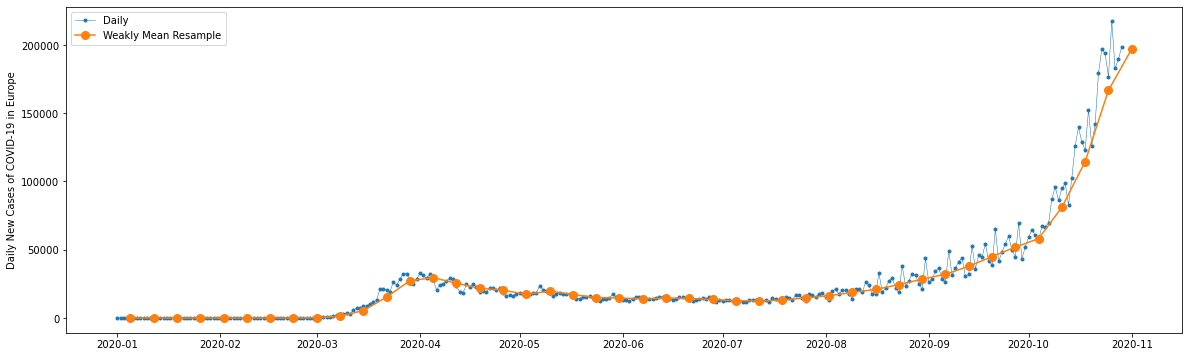

In [60]:
Initial_plot(df)

In [61]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,14)
    plt.show()

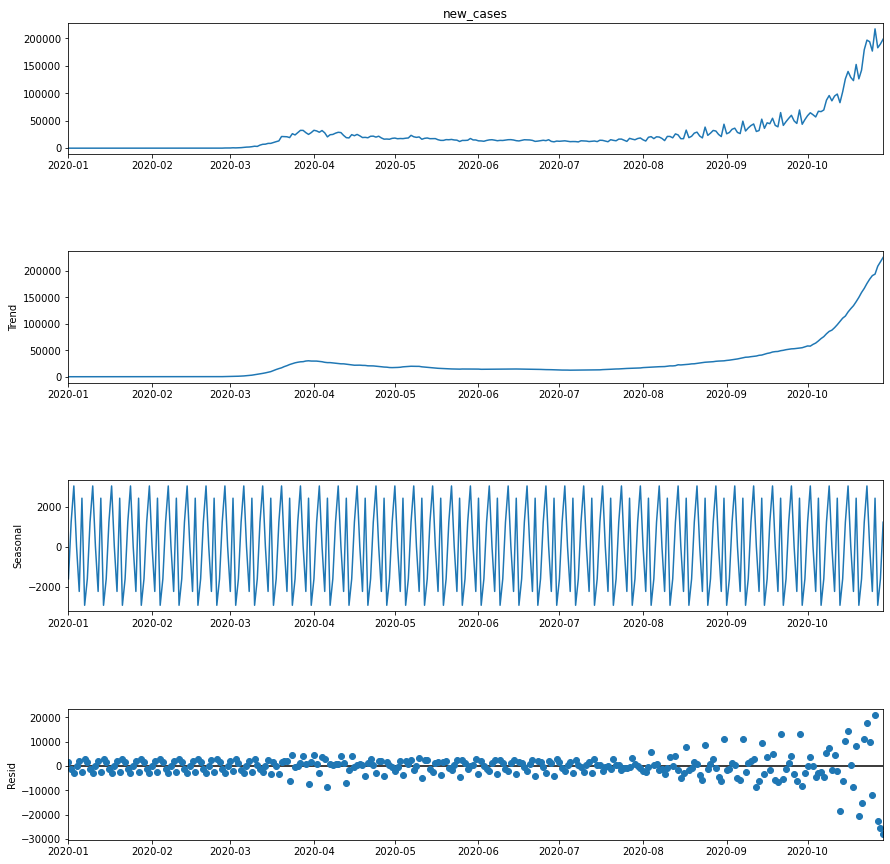

In [62]:
y = df['new_cases']
seasonal_decompose(y)

In [63]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

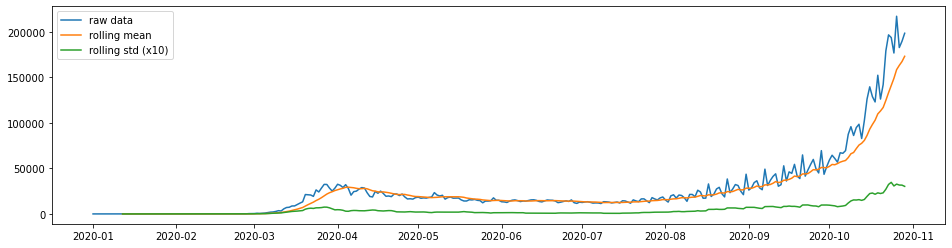

In [64]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')


In [65]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [66]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = 1.827
P-value = 0.998
Critical values :
	1%: -3.4534232986669546 - The data is not stationary with 99% confidence
	5%: -2.8716994185534745 - The data is not stationary with 95% confidence
	10%: -2.5721833625116144 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -2.852
P-value = 0.051
Critical values :
	1%: -3.455558114028747 - The data is not stationary with 99% confidence
	5%: -2.872635586277424 - The data is not stationary with 95% confidence
	10%: -2.572682677000175 - The data is  stationary with 90% confidence


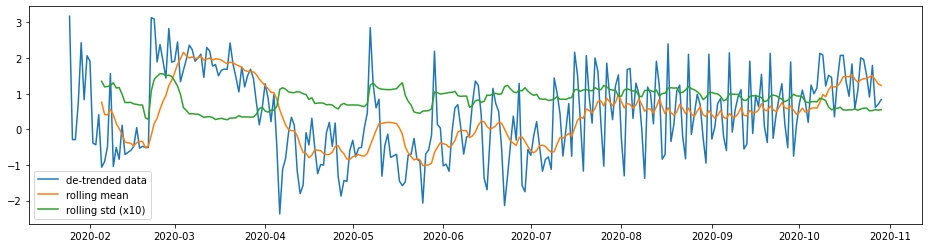

In [67]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 7 lag differenced data stationary ?
Test statistic = -1.979
P-value = 0.296
Critical values :
	1%: -3.4540076534999957 - The data is not stationary with 99% confidence
	5%: -2.8719557347997178 - The data is not stationary with 95% confidence
	10%: -2.5723200648758366 - The data is not stationary with 90% confidence


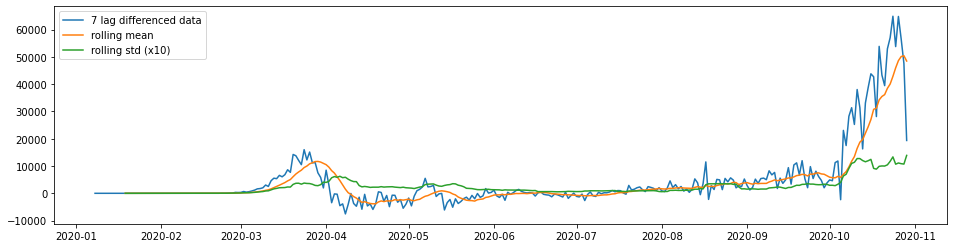

In [68]:
# Differencing
y_7lag =  y - y.shift(7)

test_stationarity(y_7lag,'7 lag differenced data')
ADF_test(y_7lag,'7 lag differenced data')

 > Is the 7 lag differenced de-trended data stationary ?
Test statistic = -4.788
P-value = 0.000
Critical values :
	1%: -3.455952927706342 - The data is  stationary with 99% confidence
	5%: -2.8728086526320302 - The data is  stationary with 95% confidence
	10%: -2.572774990685656 - The data is  stationary with 90% confidence


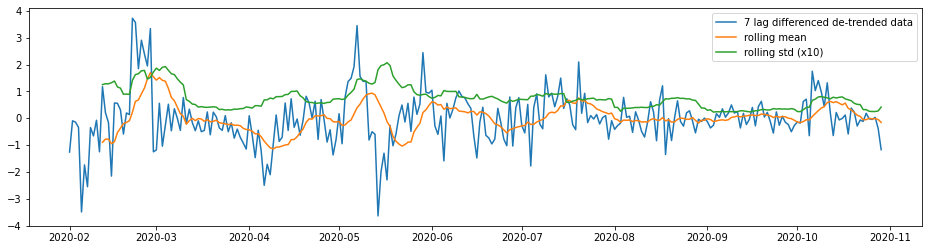

In [69]:
# Detrending + Differencing

y_7lag_detrend =  y_detrend - y_detrend.shift(7)

test_stationarity(y_7lag_detrend,'7 lag differenced de-trended data')
ADF_test(y_7lag_detrend,'7 lag differenced de-trended data')

In [120]:
#The model is not compatible for negative trend values, so we have to start it at May 1st

y = y['2020-05-01':]

y_to_train = y[:'2020-10-15'] # dataset to train
y_to_val = y # last X months for test  
predict_date = len(y) - len(y_to_train) #len(y[:'2020-09-16'])  the number of data points for the test set


In [121]:
def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 55719.53
The Root Mean Squared Error of our forecasts with auto optimization is 66570.77


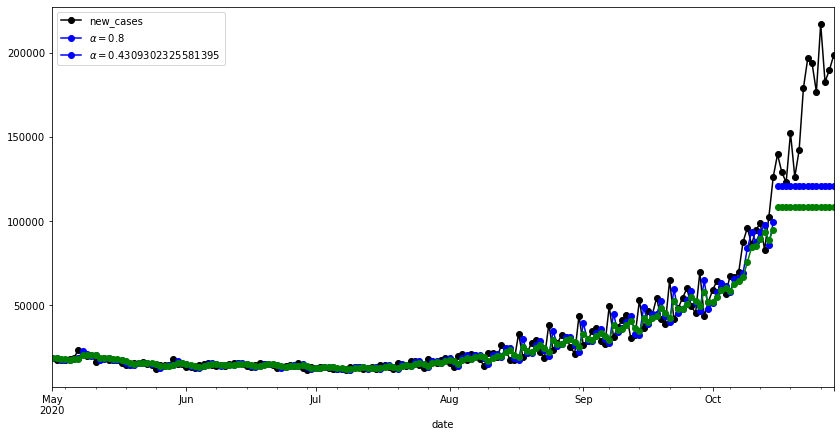

The Root Mean Squared Error of our forecasts with smoothing level of 0.5 is 64237.72
The Root Mean Squared Error of our forecasts with auto optimization is 66570.77


C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


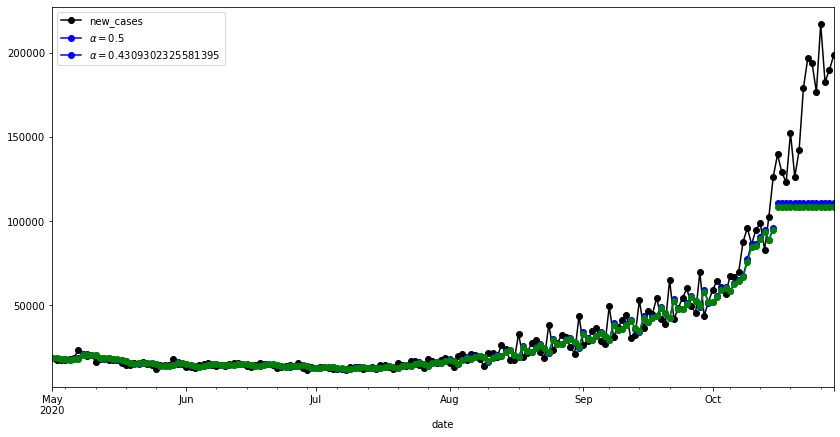

In [122]:
ses(y, y_to_train,y_to_val,0.8,predict_date)
ses(y, y_to_train,y_to_val,0.5,predict_date)

In [123]:
def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red', legend=True)
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Root Mean Squared Error of Holts Linear trend 18258.11
The Root Mean Squared Error of Holts Exponential trend 41217.32


C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


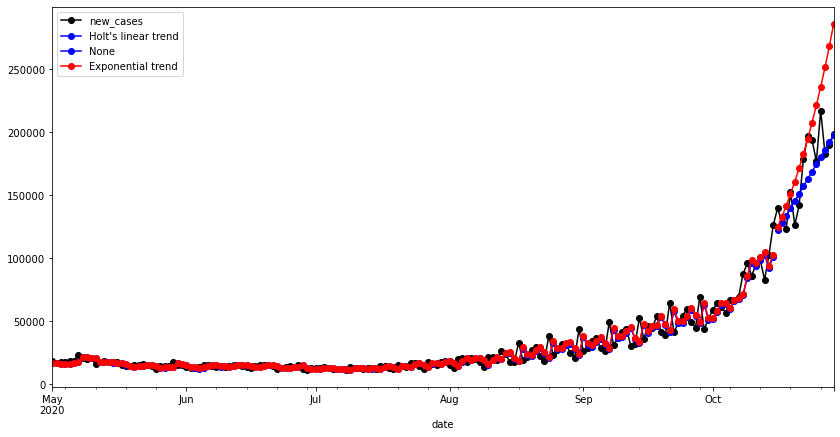

In [124]:
holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)

In [173]:
def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date, ):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    #ax.set_ylim([0,y.max()*3])
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(optimized=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} is {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        mae1 = abs(fcast1 - y_to_test).mean()
        print('The Mean Absolute Error of additive trend, additive seasonal of '+ 
              'period season_length={} is {}'.format(seasonal_period,round(mae1, 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(optimized=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} is {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        mae2 = abs(fcast2 - y_to_test).mean()
        print('The Mean Absolute Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} is {}'.format(seasonal_period,round(mae2, 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(optimized=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} is {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        mae3 = abs(fcast3 - y_to_test).mean()
        print('The Mean Absolute Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} is {}'.format(seasonal_period,round(mae3, 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(optimized=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast4 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={}, is {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        mae4 = abs(fcast4 - y_to_test).mean()
        print('The Mean Absolute Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} is {}'.format(seasonal_period,round(mae4, 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\borge\miniconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  app.launch_new_instance()
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=7 is 29647.99
The Mean Absolute Error of additive trend, additive seasonal of period season_length=7 is 25182.68
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=7 is 31437.53
The Mean Absolute Error of additive damped trend, additive seasonal of period season_length=7 is 26881.45


C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


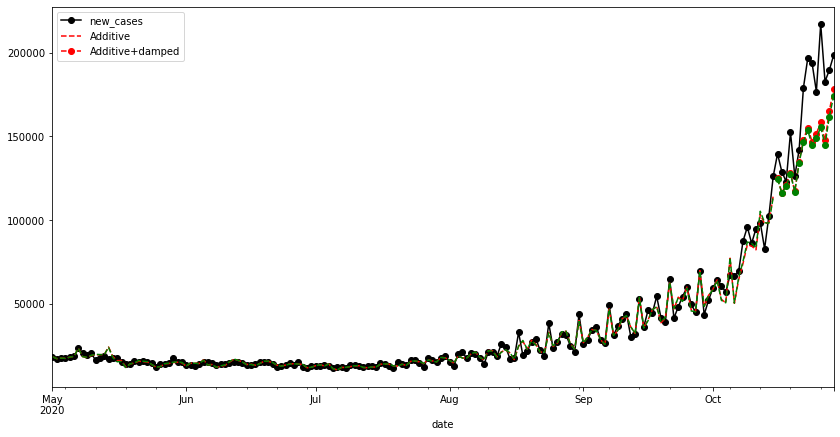

In [174]:
holt_win_sea(y, y_to_train,y_to_val,'additive',7, predict_date)

C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\borge\miniconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of additive trend, multiplicative seasonal of period season_length=7 is 29680.89
The Mean Absolute Error of additive trend, multiplicative seasonal of period season_length=7 is 24927.07
The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=7, is 32676.07
The Mean Absolute Error of additive damped trend, multiplicative seasonal of period season_length=7 is 27866.04


C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


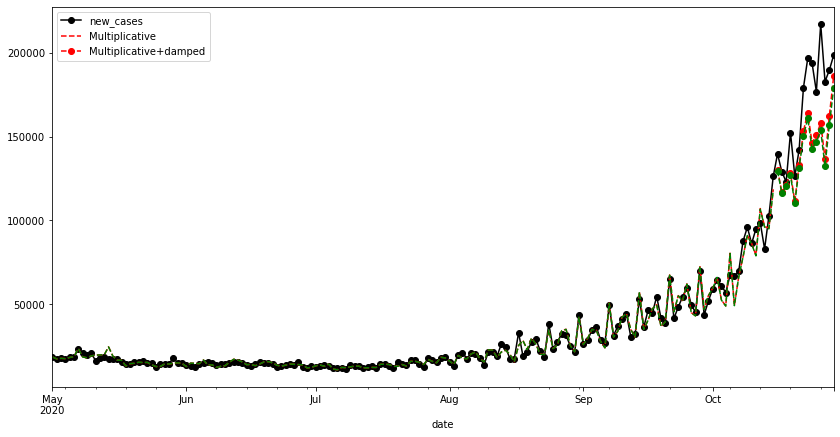

In [175]:
holt_win_sea(y, y_to_train,y_to_val,'multiplicative',7, predict_date)

In [159]:
#fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = 7, trend='add', seasonal='add').fit(optimized=True)
#fcast1 = fit1.forecast(predict_date).rename('Additive')
#mse1 = ((fcast1 - y_to_val) ** 2).mean()
#print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              #'period season_length={} and a Box-Cox transformation {}'.format(7,round(np.sqrt(mse1), 2)))
#type(fcast1)

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=7 and a Box-Cox transformation 29647.99


C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


pandas.core.series.Series

In [162]:
df1 = pd.DataFrame(fcast1)
df1

,Additive
2020-10-16,124895.70201411
2020-10-17,116498.51620999
2020-10-18,121264.34251840
2020-10-19,127959.52405991
2020-10-20,117313.63736234
2020-10-21,134773.57832885
2020-10-22,147961.28954876
2020-10-23,155336.88804505
2020-10-24,146939.70224094
2020-10-25,151705.52854934
